In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from IPython import display
## lead helper functions from d2l
import sys
sys.path.insert(0, 'C:\\Users\\Shiwen\\dl_practice_pytorch\\function')
import d2l_torch as d2l

**GoogLeNet**

Inspired by NiN in using 1x1 conv. layer

**Define Inception Block**

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # dim = 0 is batch size, dim = 1 is channel
        return torch.cat((p1, p2, p3, p4), dim=1)

**Define GoogLeNet Architecture**

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [4]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [5]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [6]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [7]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)


In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [9]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


**Load Fashion MNIST data**

In [10]:
# resize 96 -> test accuracy 0.872
# resize 224 -> test accuracy 0.88
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=96)

In [11]:
# evaluate_accuracy_gpu function depend on 
# (1) accuracy() function
# (2) Accumulator class in d2l
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2);
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [12]:
# train_gpu depends on 
# (1) d2l.Animator function
# (2) d2l.Timer class
# (3) d2l.accuracy function
# (4) evaluate_accuracy_gpu function
def train_gpu(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on ', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # pause updating the gradient while calculating evaluation metrics
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter) # no device -> cpu
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.247, train acc 0.906, test acc 0.872
1509.6 examples/sec on cuda:0


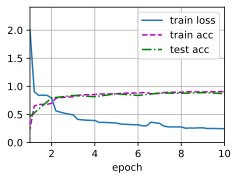

In [13]:
lr, num_epochs = 0.1, 10
train_gpu(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [16]:
def get_label(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def predict_gpu(net, test_iter, n, device):
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        break
    actuals = get_label(y)
    preds = get_label(net(X).argmax(axis = 1))
    titles = ['A: ' + actual + '\n' + 'E: ' + pred for actual, pred in zip(actuals, preds)]
    d2l.show_images(X[0:n].to('cpu').reshape((n, 96, 96)), 1, n, titles=titles[0:n])

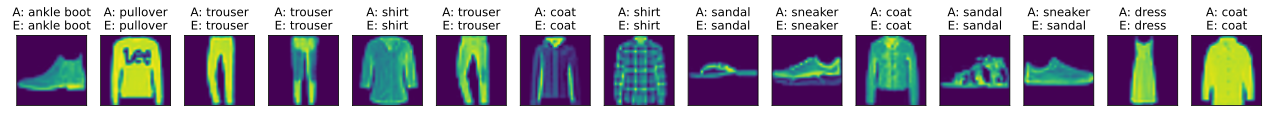

In [17]:
predict_gpu(net, test_iter, 15, d2l.try_gpu())